# Data to explore

In [1]:
# Initialize the data structure as a list of tuples
data_to_explore = []

# Example of adding ABF files and sweep numbers as tuples
data_to_explore.append(("file1.abf", 1))
data_to_explore.append(("file1.abf", 3))
data_to_explore.append(("file2.abf", 0))
data_to_explore.append(("file2.abf", 2)),


# Accessing the data
for abf_file, sweep_number in data_to_explore:
    print(f"ABF File: {abf_file}, Sweep Number: {sweep_number}")


ABF File: file1.abf, Sweep Number: 1
ABF File: file1.abf, Sweep Number: 3
ABF File: file2.abf, Sweep Number: 0
ABF File: file2.abf, Sweep Number: 2


---
# `abf` files and `pyabf` library

## ABF File Overview

An ABF (Axon Binary Format) file is a proprietary file format developed by Axon Instruments (now part of Molecular Devices) to store electrophysiological data from experiments. ABF files are commonly used to save data from experiments like patch-clamp recordings, where researchers measure electrical signals from biological systems (such as neurons or muscle cells). These files can store a variety of information, including:

- Data Traces: Time series data for one or more channels, representing signals such as voltage or current.
- Metadata: Information about the experiment, including settings for the recording, such as sampling rate, experiment type, and device configuration.
- Multiple Sweeps: An ABF file can contain multiple sweeps (individual trials or experimental runs), which may differ in parameters or conditions.

The ABF format is binary, making it efficient for large datasets, but it is not easily readable without specialized software or libraries.

## `pyabf` Library

The `pyabf` library is a Python package designed to facilitate working with ABF files. It provides an easy-to-use interface to read and manipulate data stored in ABF files. The library makes it simpler for researchers to extract relevant information from ABF files, without having to manually parse the binary data.

Key Features of pyabf:

1.	Load ABF Files: Load an ABF file into memory and provide access to its data.
2.	Access Data Traces: Extract time-series data, such as voltage and current traces (from ADC channels).
3.	Multiple Sweep Support: Handle multiple sweeps (individual experimental runs) within a single ABF file.
4.	Extract Metadata: Retrieve metadata like channel names, experiment parameters, and other settings.
5.	Sweep Navigation: Select and navigate through multiple sweeps (trials) and analyze their data individually.

Common Functions in pyabf:

- `ABF(file_path)`: Initializes an ABF object from a given file path, loading the data into memory.
- `setSweep(sweep_index)`: Selects a specific sweep (experimental run) by its index.
- `sweepY`: Extracts the voltage (or other signal) data for the current sweep.
- `sweepX`: Extracts the time vector for the current sweep.
- `sweepC`: Extracts the command input (if available) for the current sweep.
- `adcNames`: List of ADC channel names.
- `dacNames`: List of DAC channel names.

## On the net

The  [pyABF](https://pypi.org/project/pyabf/) library was created by [Scott Harden](https://swharden.com/about/).
Scott Harden has made pyABF available as an open-source library, aiming to simplify the process of working with ABF files in Python, making it easier for researchers to analyze and visualize their data. You can find more about pyABF and its documentation on his website: pyABF - A simple Python interface for Axon Binary Format ABF files.

- [pyABF - A simple Python interface for Axon Binary Format ABF files](https://swharden.com/pyabf/), with [git repository](https://github.com/swharden/pyABF)
- a [tutorial](https://swharden.com/pyabf/tutorial/) by [Scott W Harden]
- in Python Package Index [pypi](https://pypi.org/project/pyabf/)

## Basics

Where we import the `pyabf` package and load a record file:

In [2]:
!pip install ipympl               
# load the pyABF library
import pyabf  # Load pyABF
%matplotlib widget
import matplotlib.pyplot as plt
from math import *
from matplotlib.backend_bases import MouseButton
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import fsolve


file_path = "bursting/cell89basal.abf"  # we select the abf record file
abf = pyabf.ABF(file_path)              # we load it
print(abf)                              # record characteristics 

ABF (v2.6) with 1 channel (pA), sampled at 10.0 kHz, containing 30 sweeps, having no tags, with a total length of 11.11 minutes, recorded without a protocol file.


Here `abf = pyabf.ABF(file_path)` creates an `abf` object that have:
- **attributes**: data stored in the object, and
- **methods**: functions that belong to an object and can be called to perform actions

We can print more attributes:

In [3]:
print(f"{'File Path:':>20} {abf.abfFilePath}")
print(f"{'File Version:':>20} {abf.abfVersionString}")
print(f"{'Sampling Rate:':>20} {abf.dataRate} Hz")
print(f"{'Total Sweeps:':>20} {abf.sweepCount}")
print(f"{'ADC Channels:':>20} {abf.adcNames}")
print(f"{'DAC Channels:':>20} {abf.dacNames}")
print(f"{'Channel Units:':>20} {abf.sweepUnitsY}")
print(f"{'Experiment Date:':>20} {abf.abfDateTime}")

          File Path: c:\Users\manur\Desktop\python\bursting\cell89basal.abf
       File Version: 2.6.0.0
      Sampling Rate: 10000 Hz
       Total Sweeps: 30
       ADC Channels: ['Waveform']
       DAC Channels: ['AO #0']
      Channel Units: pA
    Experiment Date: 2024-11-08 00:00:50.086000


You can list all the attributes of an `abf` object with `print(abf.__dict__)`.

In [4]:
methods = [method for method in dir(abf) if callable(getattr(abf, method)) and not method.startswith("__")]
print("\n".join(methods))

_dtype
_getAdcNameAndUnits
_getDacNameAndUnits
_ide_helper
_loadAndScaleData
_makeAdditionalVariables
_readHeadersV1
_readHeadersV2
getAllXs
getAllYs
headerLaunch
launchInClampFit
saveABF1
setSweep
sweepD


You have private methods (Prefixed with _), and:

- `getAllXs()`: Returns all time points (X-values) for every sweep, useful for plotting.
- `getAllYs()`: Returns all recorded signal values (Y-values) for every sweep.
- `headerLaunch()`: Likely a utility function for debugging or inspecting header information.
- `launchInClampFit()`: Opens the ABF file in ClampFit, a software from Molecular Devices used for electrophysiology data analysis.
- `saveABF1()`: Converts and saves the ABF file in version 1 format, which is older but sometimes required for compatibility.
- `setSweep(sweepIndex)`: Sets the current sweep (i.e., trial or recording segment) to a given index for further processing.
- `sweepD`: Likely an attribute or method that provides the time duration of a sweep.

Of course the main parts of the sweep are the **recorded signal** and the **command inpput**:

In [5]:
# Print voltage trace (recorded signal)
print(f"{'Voltage Trace (mV):':>25} {abf.sweepY}")

# Print command input (if available)
print(f"{'Command Input (mV):':>25} {abf.sweepC}")

      Voltage Trace (mV): [-61.2   -60.856 -61.2   ... -56.228 -56.196 -56.353]
      Command Input (mV): [0. 0. 0. ... 0. 0. 0.]


## Basic `abf` file exploration

### `abf` attributes and methods

The `abf` object contains various attributes and methods that allow you to access metadata and data from the .abf file. Here are some useful attributes and how to call them:

In [6]:
print("List of sweep indexes:", ", ".join(map(str, abf.sweepList)))

List of sweep indexes: 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29


In [7]:
# Choose a specific sweep (e.g., first sweep -> index 0)  
sweep_index = 0  
abf.setSweep(sweep_index)  

# Print voltage trace (recorded signal)
print(f"{'Voltage Trace (mV):':>25} {abf.sweepY}")

# Print command input (if available)
print(f"{'Command Input (mV):':>25} {abf.sweepC}")

# Check all available ADC channels (recorded signals)
print(f"{'Recorded Channels:':>25} {abf.adcNames}")

# Check DAC channels (command input signals)
print(f"{'Command Channels:':>25} {abf.dacNames}")

      Voltage Trace (mV): [-61.2   -60.856 -61.2   ... -56.228 -56.196 -56.353]
      Command Input (mV): [0. 0. 0. ... 0. 0. 0.]
       Recorded Channels: ['Waveform']
        Command Channels: ['AO #0']


### Exploring all sweeps of an `abf` file


Voltage Trace Statistics:
           Mean (mV): -55.656
         Median (mV): -56.853
            Min (mV): -66.204
            Max (mV): 49.191
        Std Dev (mV): 9.172
          Range (mV): 115.395


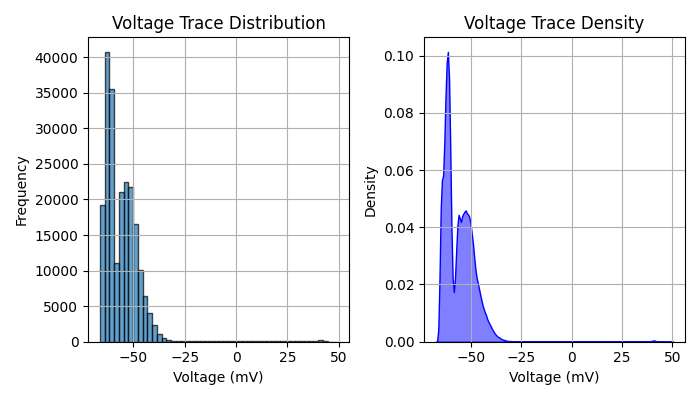

In [8]:

data = abf.sweepY  # The voltage trace

stats = {
    "Mean (mV)": np.mean(data),
    "Median (mV)": np.median(data),
    "Min (mV)": np.min(data),
    "Max (mV)": np.max(data),
    "Std Dev (mV)": np.std(data),
    "Range (mV)": np.ptp(data),  # Max - Min
}

print("\nVoltage Trace Statistics:")
for key, value in stats.items():
    print(f"{key:>20}: {value:.3f}")


import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure with two subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(7, 4))

# Plot histogram on the first subplot
axes[0].hist(data, bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel("Voltage (mV)")
axes[0].set_ylabel("Frequency")
axes[0].set_title("Voltage Trace Distribution")
axes[0].grid(True)

# Plot KDE on the second subplot
sns.kdeplot(data, bw_adjust=0.5, fill=True, color="b", alpha=0.5, ax=axes[1])
axes[1].set_xlabel("Voltage (mV)")
axes[1].set_ylabel("Density")
axes[1].set_title("Voltage Trace Density")
axes[1].grid(True)

# Adjust layout
plt.tight_layout()
plt.show()

Of course, the previous plots are not particularly interesting, as they represent the distribution of the signal while mixing both inter-burst and burst phases. A more insightful approach would be to plot the distributions separately: one for the inter-burst signal and another for the intra-burst signal. Note that the previous plots exhibit a bimodal distribution, which is certainly related to the two phases of the signal—burst and non-burst (quiescent or background activity).

In [9]:
def plot_abf():
    plt.figure(figsize=(8, 5))

    # plot every sweep (with vertical offset)
    for sweepNumber in abf.sweepList:
        abf.setSweep(sweepNumber)
        offset = 140*sweepNumber
        plt.plot(abf.sweepX, abf.sweepY+offset, color='b',lw=0.1)

    # decorate the plot
    plt.gca().get_yaxis().set_visible(False)  # hide Y axis
    plt.title(file_path)
    plt.xlabel(abf.sweepLabelX)
    plt.show()

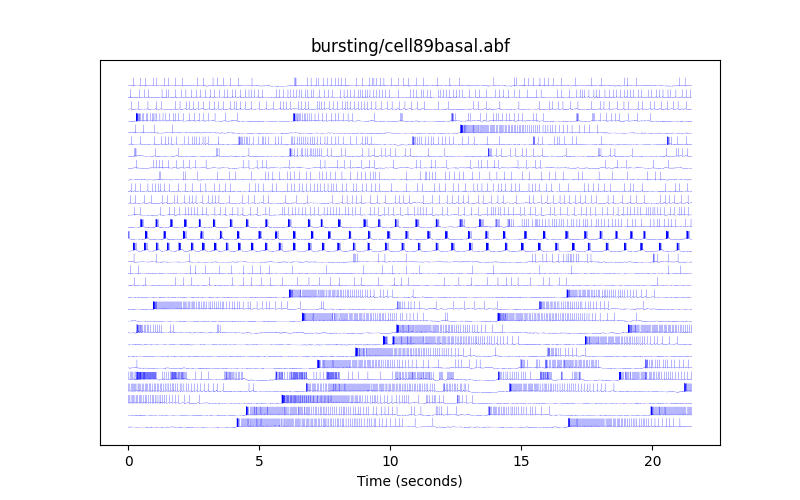

In [10]:
plot_abf()

ABF (v2.6) with 1 channel (pA), sampled at 10.0 kHz, containing 30 sweeps, having no tags, with a total length of 11.11 minutes, recorded without a protocol file.


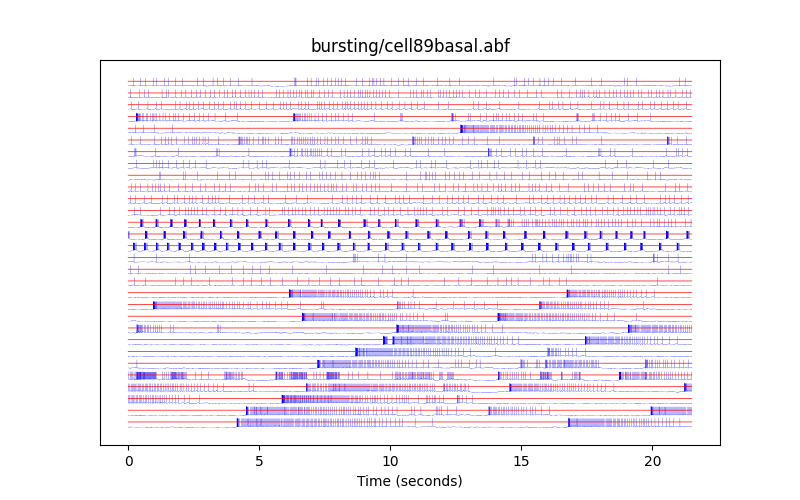

In [11]:
file_path = "bursting/cell89basal.abf"  # Select the ABF file
abf = pyabf.ABF(file_path)  # Load it
print(abf)  # Record characteristics

def plot_abf():
    plt.figure(figsize=(8, 5))

    # Plot every sweep with vertical offset
    for sweepNumber in abf.sweepList:
        abf.setSweep(sweepNumber)
        offset = 140 * sweepNumber
        plt.plot(abf.sweepX, abf.sweepY + offset, color='b', lw=0.1)  # Recorded voltage
        plt.plot(abf.sweepX, abf.sweepC + offset, color='r', lw=0.5)  # Command waveform in red

    # Decorate the plot
    plt.gca().get_yaxis().set_visible(False)  # Hide Y axis
    plt.title(file_path)
    plt.xlabel(abf.sweepLabelX)
    plt.show()

plot_abf()

ABF (v2.6) with 1 channel (pA), sampled at 10.0 kHz, containing 30 sweeps, having no tags, with a total length of 11.11 minutes, recorded without a protocol file.


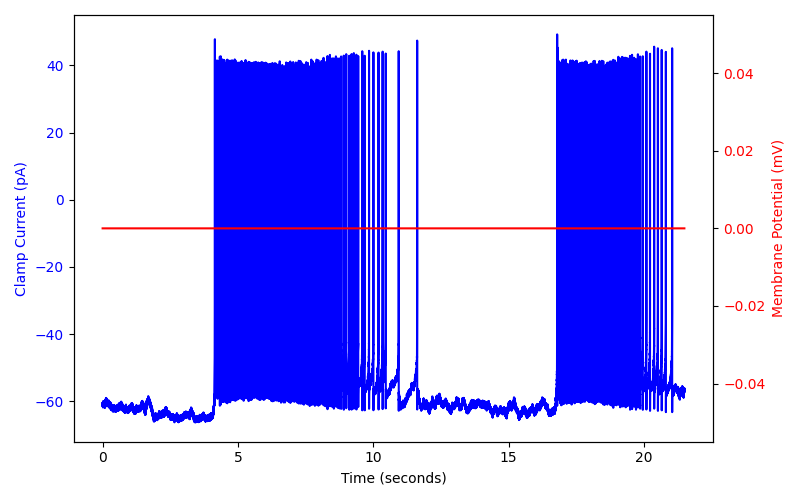

In [12]:
import pyabf  # Load pyABF
import matplotlib.pyplot as plt

file_path = "bursting/cell89basal.abf"  # Select the ABF file
abf = pyabf.ABF(file_path)  # Load it
print(abf)  # Record characteristics


# Create the figure
fig, ax1 = plt.subplots(figsize=(8, 5))

# Plot the recorded curve (ADC) on the left axis
ax1.plot(abf.sweepX, abf.sweepY, color='b', label="ADC waveform")
ax1.set_xlabel(abf.sweepLabelX)
ax1.set_ylabel(abf.sweepLabelY, color='b')
ax1.tick_params(axis='y', labelcolor='b')

# Create a second y-axis for the control curve (DAC)
ax2 = ax1.twinx()
ax2.plot(abf.sweepX, abf.sweepC, color='r', label="DAC waveform")
ax2.set_ylabel(abf.sweepLabelC, color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Improve the layout
fig.tight_layout()
plt.show()


---
# Spike detection

I build on the ideas developed by David [spikesandbursts](https://spikesandbursts.wordpress.com/about/):

> "I have utilized the function FindPeaks to analyze postsynaptic events (see [post](https://spikesandbursts.wordpress.com/2022/07/03/patch-clamp-data-analysis-in-python-postsynaptic-currents-and-potentials/)), and here I show you a simplified version to detect action potentials. For a more detailed analysis of action potentials, I recommend using the packages IPFX or EFEL (tutorials [here](https://spikesandbursts.wordpress.com/2022/05/03/patch-clamp-analysis-python-action-potentials/)). If you have already done the spike analysis, skip this part."



## Python libraries

In [13]:
import numpy as np
import pandas as pd
 
import pyabf
 
import scipy
from scipy import signal
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
from scipy.stats import skew, kurtosis
 
import matplotlib.pyplot as plt

## Load the data

In [14]:
# ABF files
data = file_path
abf = pyabf.ABF(data)
print(abf)

ABF (v2.6) with 1 channel (pA), sampled at 10.0 kHz, containing 30 sweeps, having no tags, with a total length of 11.11 minutes, recorded without a protocol file.


## Pre-process the signal: filtering

"I did not use it for this tutorial, but here is an example of how to filter the signal. More details can be found in this [post](https://spikesandbursts.wordpress.com/2022/07/03/patch-clamp-data-analysis-in-python-postsynaptic-currents-and-potentials/#preprocessing-filtering)."

In [15]:
# Sampling rate
fs = int(abf.dataPointsPerMs * 1000)
 
# Lowpass Bessel filter
b_lowpass, a_lowpass = signal.bessel(4,     # Order of the filter
                                     2000,  # Cutoff frequency
                                     'low', # Type of filter
                                     analog=False,  # Analog or digital filter
                                     norm='phase',  # Critical frequency normalization
                                     fs=fs)  # fs: sampling frequency
 
signal_filtered = signal.filtfilt(b_lowpass, a_lowpass, abf.sweepY)

## Action potentials detection: FindPeaks

"I have utilized the function FindPeaks to analyze postsynaptic events (see [post](https://spikesandbursts.wordpress.com/2022/07/03/patch-clamp-data-analysis-in-python-postsynaptic-currents-and-potentials/)), and here I show you a simplified version to detect action potentials. For a more detailed analysis of action potentials, I recommend using the packages IPFX or EFEL (tutorials [here](https://spikesandbursts.wordpress.com/2022/05/03/patch-clamp-analysis-python-action-potentials/)). If you have already done the spike analysis, skip this part."

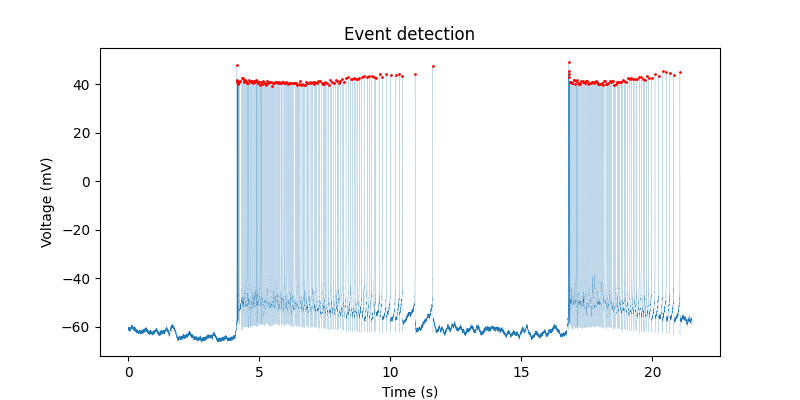

,spike,spike_index,spike_time,inst_freq,isi_s,width,rise_half_ms,decay_half_ms,spike_peak,spike_amplitude
0,1,41492,4.1492,inf,0.0000,0.530190,0.099506,0.430684,47.752998,113.268997
1,2,41545,4.1545,188.679245,0.0053,0.535173,0.198077,0.337096,41.466999,100.508999
2,3,41605,4.1605,166.666667,0.0060,0.553585,0.194615,0.358971,40.966999,98.790001
3,4,41672,4.1672,149.253731,0.0067,0.578264,0.185913,0.392351,41.623001,100.822002
4,5,41757,4.1757,117.647059,0.0085,0.595801,0.204363,0.391437,40.028999,97.350998
...,...,...,...,...,...,...,...,...,...,...
196,197,203824,20.3824,6.531679,0.1531,0.618372,0.171005,0.447368,45.533001,108.327999
197,198,205210,20.5210,7.215007,0.1386,0.615512,0.185775,0.429737,45.063000,107.201000
198,199,206622,20.6622,7.082153,0.1412,0.627193,0.225217,0.401976,44.563000,107.357998
199,200,208157,20.8157,6.514658,0.1535,0.621055,0.147202,0.473853,44.000000,106.638000


In [16]:
lista=[]
# Assign the variables here to simplify the code
time = abf.sweepX
peaks_signal = abf.sweepY  # Or signal_filtered
abf.setSweep(15)

# Set parameters for the Find peaks function (set to None if not needed)
thresh_min = -25                    # Min threshold to detect spikes
thresh_prominence = 15              # Min spike amplitude  
thresh_min_width = 0.5 * (fs/1000)  # Min required width in ms
distance_min = 1 * (fs/1000)        # Min horizontal distance between peaks
pretrigger_window = (1.5 * fs)/1000
posttrigger_window = (2 * fs)/1000
 
# Find peaks function
peaks, peaks_dict = find_peaks(peaks_signal, 
           height=thresh_min, 
           threshold=thresh_min,  
           distance=distance_min,  
           prominence=thresh_prominence,  
           width=thresh_min_width, 
           wlen=None,       # Window length to calculate prominence
           rel_height=0.5,  # Relative height at which the peak width is measured
           plateau_size=None)
  
# Create table with results
spikes_table = pd.DataFrame(columns = ['spike', 'spike_index', 'spike_time',
                                       'inst_freq', 'isi_s',
                                       'width', 'rise_half_ms', 'decay_half_ms',
                                       'spike_peak', 'spike_amplitude'])
 
spikes_table.spike = np.arange(1, len(peaks) + 1)
spikes_table.spike_index = peaks
spikes_table.spike_time = peaks / fs  # Divided by fs to get s
spikes_table.isi_s = np.diff(peaks, axis=0, prepend=peaks[0]) / fs
spikes_table.inst_freq = 1 / spikes_table.isi_s
spikes_table.width = peaks_dict['widths']/(fs/1000) # Width (ms) at half-height
spikes_table.rise_half_ms = (peaks - peaks_dict['left_ips'])/(fs/1000) 
spikes_table.decay_half_ms = (peaks_dict['right_ips'] - peaks)/(fs/1000)
spikes_table.spike_peak = peaks_dict['peak_heights']  # height parameter is needed
spikes_table.spike_amplitude = peaks_dict['prominences']  # prominence parameter is needed
      
# Plot the detected spikes in the trace
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(time, peaks_signal,lw=0.1)
 
# Red dot on each detected spike
ax.plot(peaks/fs, peaks_signal[peaks], "r.",markersize=2)
 
# Add a number to each detected peak
# for i, txt in enumerate(spikes_table.spike):  
#     ax1.annotate(spikes_table.spike[i], (peaks[i]/fs, peaks_signal[peaks][i]))
 
ax.set_title("Event detection")  
ax.set_xlabel("Time (s)")
ax.set_ylabel("Voltage (mV)")
#ax.axes.set_xlim(0.4, 0.9)  # Zoom in the trace
 
# Show graph and table
plt.show()
spikes_table

## Export the table and the plot

Documentation: [save the figure](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.savefig.html), and [table to csv](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_csv.html).

In [17]:
fig.savefig('bursting/cell89basal.png', dpi=300)
spikes_table.to_csv('bursting/cell89basal_spike_table.csv', index=False)

## Interspike Intervals

Next, the histogram of interspike intervals (ISI) helps choose reliable threshold parameters in burst analysis. If you already have a table with the action potential results, load the ISIs data into the variable `hist_data`.

The code below will plot the histogram and calculate some distribution statistics. Additionally, I have simplified the cumulative moving average (Kapucu et al., 2012) to find peaks and valleys.
- Skewness quantifies distribution symmetry: 0 (symmetrical), positive (longer right tail), negative (longer left tail). Rule of thumb: skew > 1 or <-1 means significant.
- Kurtosis quantifies tail similarity to the Gaussian distribution: 0 (Gaussian), negative (fewer tail values than Gaussian), positive (more tail values).

Of course, the ISI distribution of the pyloric dilator neuron has an ideal bimodal distribution, while the ISI distribution is noisier in other cases. This makes threshold calculations challenging and beyond the scope of this tutorial. However, if you are interested, explore burst detection algorithms using ISI in [Pasquale et al., 2010](https://link.springer.com/article/10.1007/s10827-009-0175-1), [Kapucu et al., 2012](https://pmc.ncbi.nlm.nih.gov/articles/PMC3378047/), and [Bakkum et al., 2014](https://www.frontiersin.org/journals/computational-neuroscience/articles/10.3389/fncom.2013.00193/full).

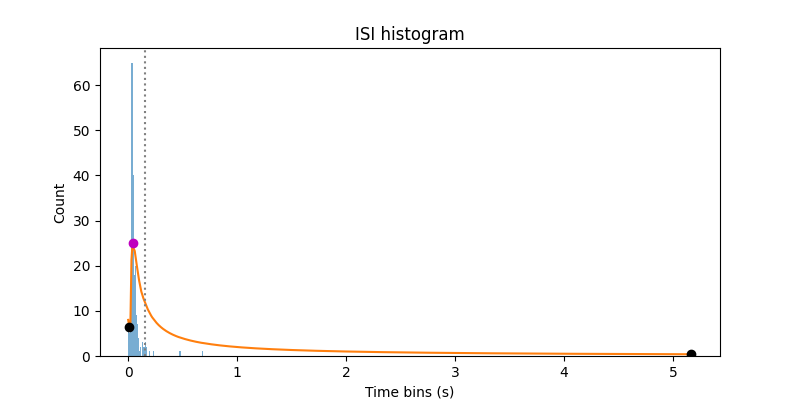

,mean_isi,median_isi,kurtosis,skewness,cma_threshold,cma_valley_time,cma_peak_time
0,0.084071,0.0431,222.864529,14.087052,0.15,5.15,0.04


In [18]:
# Assign ISI data to this variable
hist_data = spikes_table['isi_s']
 
# Empty DataFrame for histogram stats
hist_stats = pd.DataFrame()
 
# Bin size
bin_size = 10  # in miliseconds
 
# Histogram
isi_range = np.ptp(hist_data)
bins = int((isi_range * 1000 / bin_size) + 0.5)  # Round to the nearest integer
hist = np.histogram(hist_data, bins=bins)
hist_counts = hist[0]
hist_bins = hist[1]
 
# Cumulative moving average
cum = np.cumsum(hist_counts)  # Cumulative sum
cma = cum / np.arange(1, len(cum) + 1)
 
# Calculate peaks and valleys of the cma
cma_peaks_indexes = scipy.signal.argrelextrema(cma, np.greater)
cma_valleys_indexes = scipy.signal.argrelextrema(cma, np.less)
 
# Select the peak you're interested in
peak_index = cma_peaks_indexes[0][0]  # Change second number to select the peak
alpha = cma[peak_index] * 0.5  # Half-peak, adapt the value to your threshold criterion
 
# Calculate cma_threshold_index relative to the selected cma_peak
cma_threshold = (np.argmin(cma[peak_index:] >= alpha) + peak_index) * bin_size/1000
 
# Dataframe with histogram statistics
length = len(hist_stats)
hist_stats.loc[length, 'mean_isi'] = np.mean(hist_data)
hist_stats.loc[length, 'median_isi'] = np.median(hist_data)
hist_stats.loc[length, 'kurtosis'] = kurtosis(hist_counts)
hist_stats.loc[length, 'skewness'] = skew(hist_counts, bias=True)
hist_stats.loc[length, 'cma_threshold'] = cma_threshold
hist_stats.loc[length, 'cma_valley_time'] = cma_valleys_indexes[0][1] * bin_size/1000  # Change peak index as needed
hist_stats.loc[length, 'cma_peak_time'] = cma_peaks_indexes[0][0] * bin_size/1000  # Change peak index as needed
 
# Plot ISI histogram
fig, ax = plt.subplots(figsize=(8, 4))
ax.set_title("ISI histogram") 
ax.hist(hist_data, bins=bins, alpha=0.6)
 
# Plot CMA
cma_x = np.linspace(np.min(hist_bins), np.max(hist_bins), bins)
ax.plot(cma_x, cma)
 
# Plot CMA threshold line
ax.axvline(cma_threshold, linestyle="dotted", color="gray")
 
# Plot CMA valleys
ax.plot(cma_x[cma_valleys_indexes], cma[cma_valleys_indexes], 'ko')
ax.plot(cma_x[cma_peaks_indexes], cma[cma_peaks_indexes], 'mo')
 
# ax.set_xscale('log')  # Logarithmic scale may be easier to set the threshold
ax.set_xlabel("Time bins (s)")
ax.set_ylabel("Count")
 
# Show graph and table
plt.show()
hist_stats

Let's do something simpler:

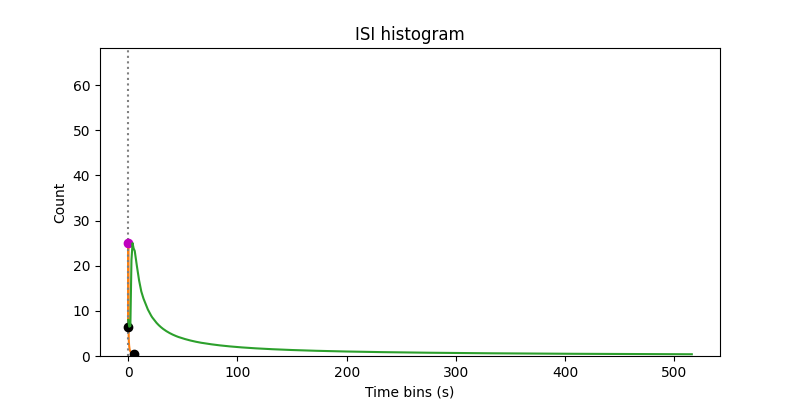

In [19]:
# Assign ISI data to this variable
hist_data = spikes_table['isi_s']
 
# Empty DataFrame for histogram stats
hist_stats = pd.DataFrame()
 
# Bin size
bin_size = 10  # in miliseconds
 
# Histogram
isi_range = np.ptp(hist_data)
bins = int((isi_range * 1000 / bin_size) + 0.5)  # Round to the nearest integer
hist = np.histogram(hist_data, bins=bins)
hist_counts = hist[0]
hist_bins = hist[1]
 
# Cumulative moving average
mycum = np.cumsum(hist_counts)  # Cumulative sum
mycma = mycum / np.arange(1, len(mycum) + 1)

plt.plot(mycma)
plt.show()


# Burst detection & classification, example of cell number 089 (6 in the new numbering), sweep number 15

In [20]:
import pyabf  # Load pyABF
import matplotlib.pyplot as plt
%matplotlib widget
from math import *
from matplotlib.backend_bases import MouseButton
import numpy as np
import pandas as pd
import scipy
from scipy import signal
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
from scipy.stats import skew, kurtosis
import seaborn as sns

In [21]:
file_path_89 = "bursting/cell91basal.abf"  # we select the abf record file
abf = pyabf.ABF(file_path_89)                 # we load it
print(abf)                                    # record characteristics 

ABF (v2.6) with 1 channel (pA), sampled at 10.0 kHz, containing 9 sweeps, having no tags, with a total length of 3.58 minutes, recorded without a protocol file.


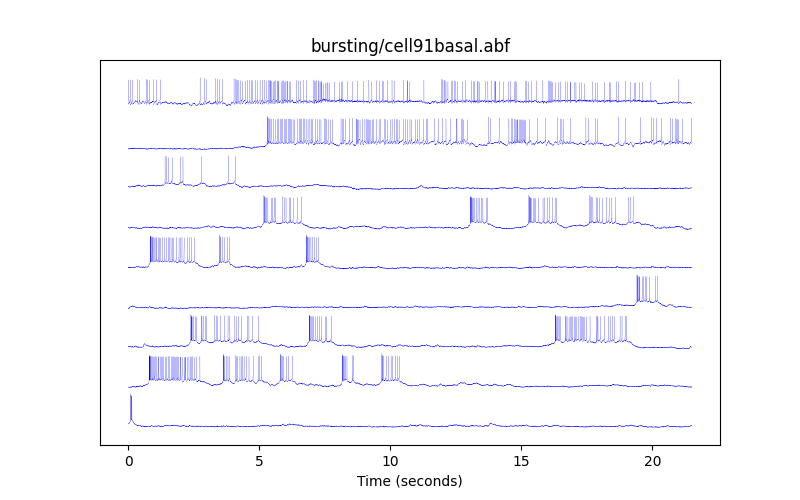

In [22]:
def plot_abf():
    plt.figure(figsize=(8, 5))

    # Plot every sweep with vertical offset
    for sweepNumber in abf.sweepList:
        abf.setSweep(sweepNumber)
        offset = 140 * sweepNumber
        plt.plot(abf.sweepX, abf.sweepY + offset, color='b', lw=0.1)  # Recorded voltage
        #plt.plot(abf.sweepX, abf.sweepC + offset, color='r', lw=0.5)  # Command waveform in red

    # Decorate the plot
    plt.gca().get_yaxis().set_visible(False)  # Hide Y axis
    plt.title(file_path_89)
    plt.xlabel(abf.sweepLabelX)
    plt.show()

plot_abf()

In [23]:
# Sampling rate
fs = int(abf.dataPointsPerMs * 1000)

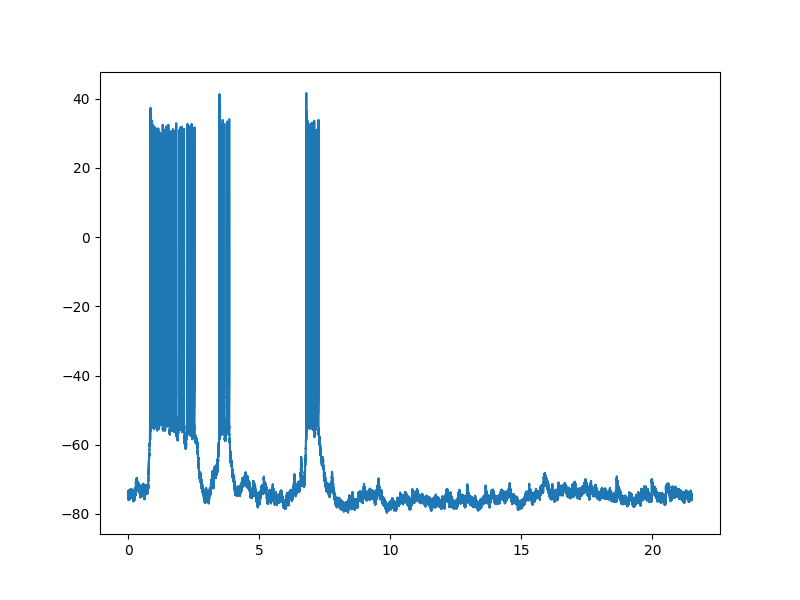

In [24]:
# Assign the variables here to simplify the code
abf.setSweep(4)
time = abf.sweepX
peaks_signal = abf.sweepY  # Or signal_filtered

plt.figure(figsize=(8, 6))
plt.plot(time,peaks_signal)
plt.show()

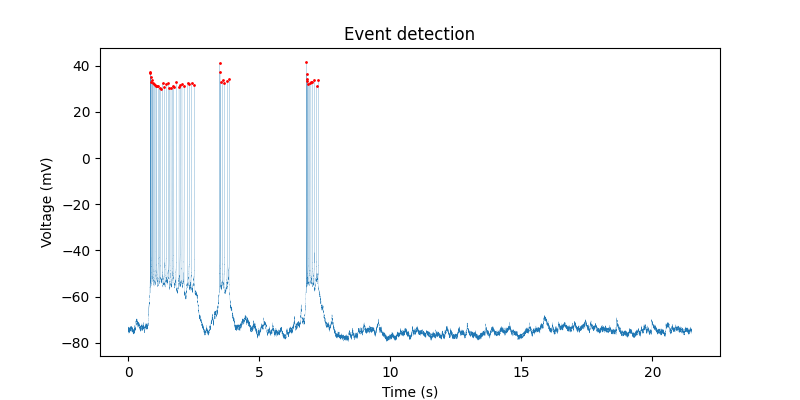

,spike,spike_index,spike_time,inst_freq,isi_s,width,rise_half_ms,decay_half_ms,spike_peak,spike_amplitude
0,1,8395,0.8395,inf,0.0000,0.387481,0.189679,0.197802,36.776001,95.287003
1,2,8512,0.8512,85.470085,0.0117,0.551660,0.205180,0.346480,37.369999,113.736996
2,3,8652,0.8652,71.428571,0.0140,0.533523,0.179913,0.353611,35.275002,91.315002
3,4,8826,0.8826,57.471264,0.0174,0.624057,0.197920,0.426137,32.772999,87.062000
4,5,9096,0.9096,37.037037,0.0270,0.655709,0.192466,0.463243,33.680000,89.032001
5,6,9349,0.9349,39.525692,0.0253,0.672938,0.219067,0.453871,32.460999,85.060997
6,7,9715,0.9715,27.322404,0.0366,0.719402,0.209712,0.509690,32.117001,85.779999
7,8,10188,1.0188,21.141649,0.0473,0.640510,0.220831,0.419679,31.773001,87.281000
8,9,10599,1.0599,24.330900,0.0411,0.673918,0.255191,0.418727,31.115999,84.059999
9,10,10949,1.0949,28.571429,0.0350,0.750423,0.263654,0.486768,31.365999,86.436998


In [25]:
# Set parameters for the Find peaks function (set to None if not needed)
thresh_min = -35                    # Min threshold to detect spikes
thresh_prominence = 15              # Min spike amplitude  
thresh_min_width = 0.3 * (fs/1000)  # Min required width in ms
distance_min = 1 * (fs/1000)        # Min horizontal distance between peaks
pretrigger_window = (1.5 * fs)/1000
posttrigger_window = (2 * fs)/1000
 
# Find peaks function
peaks, peaks_dict = find_peaks(peaks_signal, 
           height=thresh_min, 
           threshold=thresh_min,  
           distance=distance_min,  
           prominence=thresh_prominence,  
           width=thresh_min_width, 
           wlen=None,       # Window length to calculate prominence
           rel_height=0.5,  # Relative height at which the peak width is measured
           plateau_size=None)
  
# Create table with results
spikes_table = pd.DataFrame(columns = ['spike', 'spike_index', 'spike_time',
                                       'inst_freq', 'isi_s',
                                       'width', 'rise_half_ms', 'decay_half_ms',
                                       'spike_peak', 'spike_amplitude'])
 
spikes_table.spike = np.arange(1, len(peaks) + 1)
spikes_table.spike_index = peaks
spikes_table.spike_time = peaks / fs  # Divided by fs to get s
spikes_table.isi_s = np.diff(peaks, axis=0, prepend=peaks[0]) / fs
spikes_table.inst_freq = 1 / spikes_table.isi_s
spikes_table.width = peaks_dict['widths']/(fs/1000) # Width (ms) at half-height
spikes_table.rise_half_ms = (peaks - peaks_dict['left_ips'])/(fs/1000) 
spikes_table.decay_half_ms = (peaks_dict['right_ips'] - peaks)/(fs/1000)
spikes_table.spike_peak = peaks_dict['peak_heights']  # height parameter is needed
spikes_table.spike_amplitude = peaks_dict['prominences']  # prominence parameter is needed
      
# Plot the detected spikes in the trace
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(time, peaks_signal,lw=0.1)
 
# Red dot on each detected spike
ax.plot(peaks/fs, peaks_signal[peaks], "r.",markersize=2)
 
# Add a number to each detected peak
# for i, txt in enumerate(spikes_table.spike):  
#     ax1.annotate(spikes_table.spike[i], (peaks[i]/fs, peaks_signal[peaks][i]))
 
ax.set_title("Event detection")  
ax.set_xlabel("Time (s)")
ax.set_ylabel("Voltage (mV)")
#ax.axes.set_xlim(0.4, 0.9)  # Zoom in the trace
 
# Show graph and table
plt.show()
spikes_table

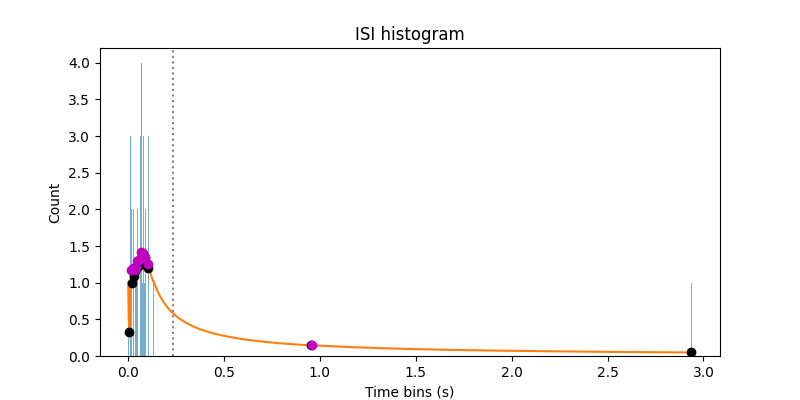

,mean_isi,median_isi,kurtosis,skewness,cma_threshold,cma_valley_time,cma_peak_time
0,0.133752,0.0555,65.364431,7.732701,0.234,0.021,0.015


In [26]:
# Assign ISI data to this variable
hist_data = spikes_table['isi_s']
 
# Empty DataFrame for histogram stats
hist_stats = pd.DataFrame()
 
# Bin size
bin_size = 3  # in miliseconds
 
# Histogram
isi_range = np.ptp(hist_data)
bins = int((isi_range * 1000 / bin_size) + 0.5)  # Round to the nearest integer
hist = np.histogram(hist_data, bins=bins)
hist_counts = hist[0]
hist_bins = hist[1]
 
# Cumulative moving average
cum = np.cumsum(hist_counts)  # Cumulative sum
cma = cum / np.arange(1, len(cum) + 1)
 
# Calculate peaks and valleys of the cma
cma_peaks_indexes = scipy.signal.argrelextrema(cma, np.greater)
cma_valleys_indexes = scipy.signal.argrelextrema(cma, np.less)
 
# Select the peak you're interested in
peak_index = cma_peaks_indexes[0][0]  # Change second number to select the peak
alpha = cma[peak_index] * 0.5  # Half-peak, adapt the value to your threshold criterion
 
# Calculate cma_threshold_index relative to the selected cma_peak
cma_threshold = (np.argmin(cma[peak_index:] >= alpha) + peak_index) * bin_size/1000
 
# Dataframe with histogram statistics
length = len(hist_stats)
hist_stats.loc[length, 'mean_isi'] = np.mean(hist_data)
hist_stats.loc[length, 'median_isi'] = np.median(hist_data)
hist_stats.loc[length, 'kurtosis'] = kurtosis(hist_counts)
hist_stats.loc[length, 'skewness'] = skew(hist_counts, bias=True)
hist_stats.loc[length, 'cma_threshold'] = cma_threshold
hist_stats.loc[length, 'cma_valley_time'] = cma_valleys_indexes[0][1] * bin_size/1000  # Change peak index as needed
hist_stats.loc[length, 'cma_peak_time'] = cma_peaks_indexes[0][0] * bin_size/1000  # Change peak index as needed
 
# Plot ISI histogram
fig, ax = plt.subplots(figsize=(8, 4))
ax.set_title("ISI histogram") 
ax.hist(hist_data, bins=bins, alpha=0.6)
 
# Plot CMA
cma_x = np.linspace(np.min(hist_bins), np.max(hist_bins), bins)
ax.plot(cma_x, cma)
 
# Plot CMA threshold line
ax.axvline(cma_threshold, linestyle="dotted", color="gray")
 
# Plot CMA valleys
ax.plot(cma_x[cma_valleys_indexes], cma[cma_valleys_indexes], 'ko')
ax.plot(cma_x[cma_peaks_indexes], cma[cma_peaks_indexes], 'mo')
 
# ax.set_xscale('log')  # Logarithmic scale may be easier to set the threshold
ax.set_xlabel("Time bins (s)")
ax.set_ylabel("Count")
 
# Show graph and table
plt.show()
hist_stats

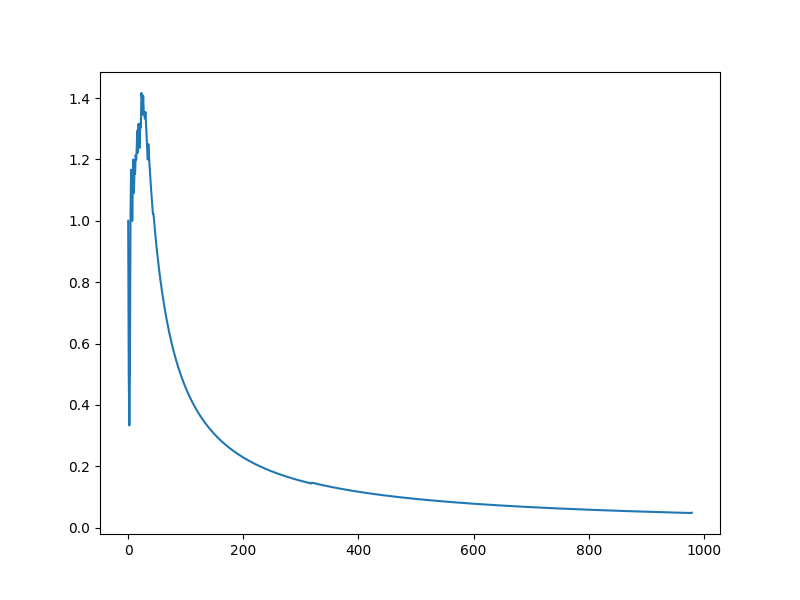

In [27]:
# Assign ISI data to this variable
hist_data = spikes_table['isi_s']
 
# Empty DataFrame for histogram stats
hist_stats = pd.DataFrame()
 
# Bin size
bin_size = 3  # in miliseconds
 
# Histogram
isi_range = np.ptp(hist_data)
bins = int((isi_range * 1000 / bin_size) + 0.5)  # Round to the nearest integer
hist = np.histogram(hist_data, bins=bins)
hist_counts = hist[0]
hist_bins = hist[1]
 
# Cumulative moving average
mycum = np.cumsum(hist_counts)  # Cumulative sum
mycma = mycum / np.arange(1, len(mycum) + 1)

plt.figure(figsize=(8, 6))
plt.plot(mycma)
plt.show()

In [28]:
abf = pyabf.ABF(file_path_89)
abf.setSweep(4)

# Extract sweep data
time = abf.sweepX  # Time axis for the sweep
voltage = abf.sweepY  # Voltage data for the sweep

# Detect spikes using a threshold or peak detection
threshold = -35  # Set your voltage threshold for spike detection (e.g., -20 mV)
spike_indices, _ = find_peaks(voltage, height=threshold)

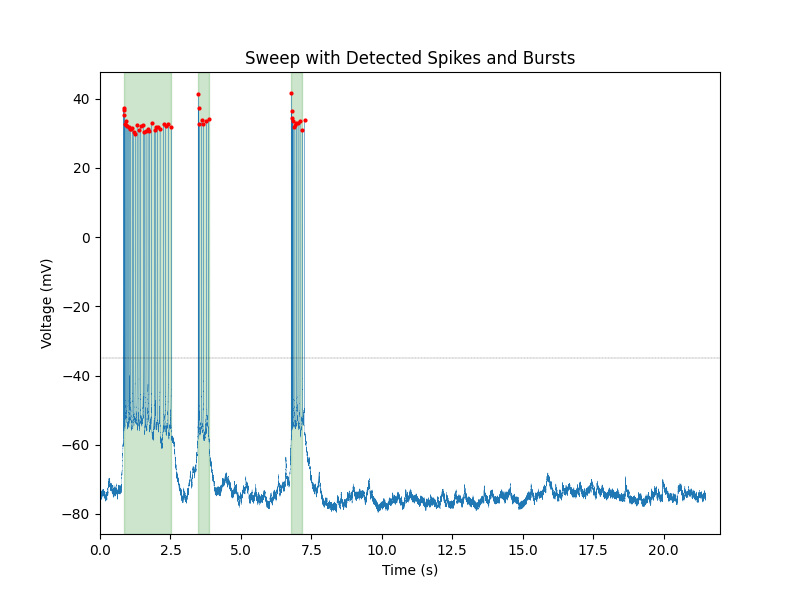

In [29]:
# Detect spikes
threshold = -35  # Set your voltage threshold for spike detection (e.g., -20 mV)
spike_indices, _ = find_peaks(voltage, height=threshold)
spike_times = time[spike_indices]  # Convert spike indices to times

# Detect bursts based on ISI
isi = np.diff(spike_times)  # Inter-spike intervals
burst_threshold = 0.3  # Define an ISI threshold for bursts (e.g., 20 ms)

# Identify bursts
bursts = []
current_burst = [spike_times[0]]  # Initialize the first burst with the first spike
for i in range(1, len(isi)):
    if isi[i - 1] < burst_threshold:  # Continue the burst
        current_burst.append(spike_times[i])
    else:  # End the current burst and start a new one
        if len(current_burst) > 1:  # Only consider bursts with more than 1 spike
            bursts.append((current_burst[0], current_burst[-1]))
        current_burst = [spike_times[i]]
# Add the last burst if valid
if len(current_burst) > 1:
    bursts.append((current_burst[0], current_burst[-1]))

# Plot the sweep, spikes, and bursts
plt.figure(figsize=(8, 6))
plt.plot(time, voltage, label='Sweep Data',lw=0.2)
plt.plot(time[spike_indices], voltage[spike_indices], 'r.', label='Spikes', markersize=4)

# Highlight bursts with shaded regions
for burst_start, burst_end in bursts:
    plt.axvspan(burst_start, burst_end, color='green', alpha=0.2, label='Burst')

plt.axhline(threshold, color='k', linestyle='--', label='Threshold',lw=0.2)
plt.xlabel("Time (s)")
plt.ylabel("Voltage (mV)")
plt.title("Sweep with Detected Spikes and Bursts")
plt.xlim((0,22))
#plt.legend()
plt.show()

# Print detected bursts
#for i, (burst_start, burst_end) in enumerate(bursts):
#    print(f"Burst {i + 1}: Start = {burst_start:.3f} s, End = {burst_end:.3f} s")

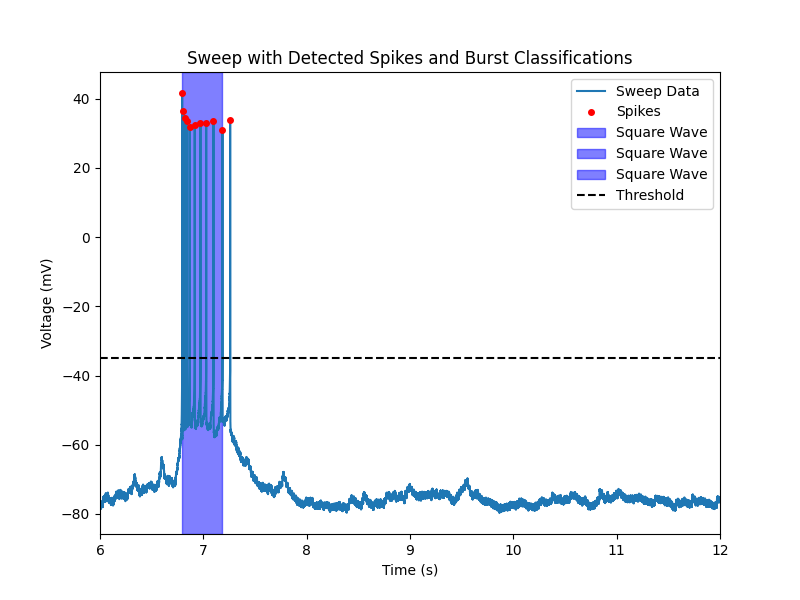

Square Wave Bursts:
  Burst 1: Start = 0.840 s, End = 2.527 s
  Burst 2: Start = 3.485 s, End = 3.855 s
  Burst 3: Start = 6.795 s, End = 7.185 s

Parabolic Bursts:

Other Bursts:


In [30]:
# Initialize lists for categorized bursts
square_wave_bursts = []
parabolic_bursts = []
other_bursts = []

for i, (burst_start, burst_end) in enumerate(bursts):
    # Calculate the minimum voltage during the burst
    burst_mask = (time >= burst_start) & (time <= burst_end)
    burst_min_voltage = np.min(voltage[burst_mask])

    # Calculate mean voltage during the preceding inter-burst interval
    if i > 0:  # Check if there's a previous burst
        prev_end = bursts[i - 1][1]
        inter_burst_prev_mask = (time > prev_end) & (time < burst_start)
        prev_mean_voltage = np.mean(voltage[inter_burst_prev_mask])
    else:
        prev_mean_voltage = float('nan')  # No previous interval, ignore in comparison
    #curr_start = bursts[i][0]
    #bef_curr_burst_mask = (time > curr_start-1) & (time < curr_start)
    #prev_mean_voltage = np.mean(voltage[bef_curr_burst_mask])
        
    # Calculate mean voltage during the succeeding inter-burst interval
    if i < len(bursts) - 1:  # Check if there's a next burst
        next_start = bursts[i + 1][0]
        inter_burst_next_mask = (time > burst_end) & (time < next_start)
        next_mean_voltage = np.mean(voltage[inter_burst_next_mask])
    else:
        next_mean_voltage = float('nan')  # No next interval, ignore in comparison
    #curr_end = bursts[i][1]
    #aft_curr_burst_mask = (time > curr_end) & (time < curr_end+1)
    #next_mean_voltage = np.mean(voltage[aft_curr_burst_mask])
        
    # Calculate overall inter-burst mean voltage
    inter_burst_mean = np.nanmean([prev_mean_voltage, next_mean_voltage])

    # Test conditions to classify the burst
    if burst_min_voltage > inter_burst_mean:
        square_wave_bursts.append((burst_start, burst_end))
    elif burst_min_voltage < inter_burst_mean:
        parabolic_bursts.append((burst_start, burst_end))
    else:
        other_bursts.append((burst_start, burst_end))

# Plot the sweep with classified bursts highlighted
plt.figure(figsize=(8, 6))
plt.plot(time, voltage, label='Sweep Data')
plt.plot(time[spike_indices], voltage[spike_indices], 'r.', label='Spikes', markersize=8)

# Highlight bursts with a single legend entry per category
square_wave_patch = None
parabolic_patch = None
other_patch = None

for burst_start, burst_end in square_wave_bursts:
    square_wave_patch = plt.axvspan(burst_start, burst_end, color='blue', alpha=0.5, label='Square Wave')

for burst_start, burst_end in parabolic_bursts:
    parabolic_patch = plt.axvspan(burst_start, burst_end, color='green', alpha=0.5, label='Parabolic')

for burst_start, burst_end in other_bursts:
    other_patch = plt.axvspan(burst_start, burst_end, color='orange', alpha=0.5, label='Other')

# Filter out None handles
#handles = [patch for patch in [square_wave_patch, parabolic_patch, other_patch] if patch is not None]
#labels = ['Square Wave', 'Parabolic', 'Other'][:len(handles)]

# Add a single legend entry for each classification
#plt.legend(handles, labels)

plt.axhline(threshold, color='k', linestyle='--', label='Threshold')
plt.xlabel("Time (s)")
plt.ylabel("Voltage (mV)")
plt.title("Sweep with Detected Spikes and Burst Classifications")
plt.xlim((6,12))
plt.legend()
plt.show()

# Print results
print("Square Wave Bursts:")
for i, (burst_start, burst_end) in enumerate(square_wave_bursts):
    print(f"  Burst {i + 1}: Start = {burst_start:.3f} s, End = {burst_end:.3f} s")

print("\nParabolic Bursts:")
for i, (burst_start, burst_end) in enumerate(parabolic_bursts):
    print(f"  Burst {i + 1}: Start = {burst_start:.3f} s, End = {burst_end:.3f} s")

print("\nOther Bursts:")
for i, (burst_start, burst_end) in enumerate(other_bursts):
    print(f"  Burst {i + 1}: Start = {burst_start:.3f} s, End = {burst_end:.3f} s")

# Save figure in PDF
plt.savefig("BurstDetection_Cell89(06)_Sweep15.pdf", format="pdf", bbox_inches="tight")

In [31]:
spike_time=spikes_table['spike_time']


In [32]:
def categorize_time_instants(L1, L2):
    L3 = []
    for start_time, end_time in L1:
        sublist = [(t, i) for i, t in enumerate(L2) if start_time <= t <= end_time]
        L3.append(sublist)
    return L3

In [33]:
L1=bursts
L2=spike_time
L3=categorize_time_instants(L1,L2)
print(L3)

[[(0.8395, 0), (0.8512, 1), (0.8652, 2), (0.8826, 3), (0.9096, 4), (0.9349, 5), (0.9715, 6), (1.0188, 7), (1.0599, 8), (1.0949, 9), (1.1494, 10), (1.1991, 11), (1.2468, 12), (1.3162, 13), (1.3834, 14), (1.4483, 15), (1.5333, 16), (1.5684, 17), (1.6334, 18), (1.7046, 19), (1.7436, 20), (1.8338, 21), (1.9394, 22), (1.9826, 23), (2.0523, 24), (2.1315, 25), (2.265, 26), (2.3298, 27), (2.4212, 28), (2.5273, 29)], [(3.4845, 30), (3.5028, 31), (3.5286, 32), (3.6066, 33), (3.6695, 34), (3.7762, 35), (3.8548, 36)], [(6.7945, 37), (6.8079, 38), (6.8225, 39), (6.84, 40), (6.8677, 41), (6.9167, 42), (6.9719, 43), (7.0277, 44), (7.0978, 45), (7.1848, 46)]]


In [34]:
L3ext = []
for start_time, end_time in L1:
    sublist = [[t, i, hist_data[i]] for i, t in enumerate(L2) if start_time <= t <= end_time]
    L3ext.append(sublist)
print(L3ext)

[[[0.8395, 0, np.float64(0.0)], [0.8512, 1, np.float64(0.0117)], [0.8652, 2, np.float64(0.014)], [0.8826, 3, np.float64(0.0174)], [0.9096, 4, np.float64(0.027)], [0.9349, 5, np.float64(0.0253)], [0.9715, 6, np.float64(0.0366)], [1.0188, 7, np.float64(0.0473)], [1.0599, 8, np.float64(0.0411)], [1.0949, 9, np.float64(0.035)], [1.1494, 10, np.float64(0.0545)], [1.1991, 11, np.float64(0.0497)], [1.2468, 12, np.float64(0.0477)], [1.3162, 13, np.float64(0.0694)], [1.3834, 14, np.float64(0.0672)], [1.4483, 15, np.float64(0.0649)], [1.5333, 16, np.float64(0.085)], [1.5684, 17, np.float64(0.0351)], [1.6334, 18, np.float64(0.065)], [1.7046, 19, np.float64(0.0712)], [1.7436, 20, np.float64(0.039)], [1.8338, 21, np.float64(0.0902)], [1.9394, 22, np.float64(0.1056)], [1.9826, 23, np.float64(0.0432)], [2.0523, 24, np.float64(0.0697)], [2.1315, 25, np.float64(0.0792)], [2.265, 26, np.float64(0.1335)], [2.3298, 27, np.float64(0.0648)], [2.4212, 28, np.float64(0.0914)], [2.5273, 29, np.float64(0.1061)]

In [35]:
# Extract second and third columns from L3ext
times = [t for sublist in L3ext for t, _, _ in sublist]  # First column (indices)
indices = [i for sublist in L3ext for _, i, _ in sublist]  # Second column (indices)
hist_values = [h for sublist in L3ext for _, _, h in sublist]  # Third column (hist_data values)

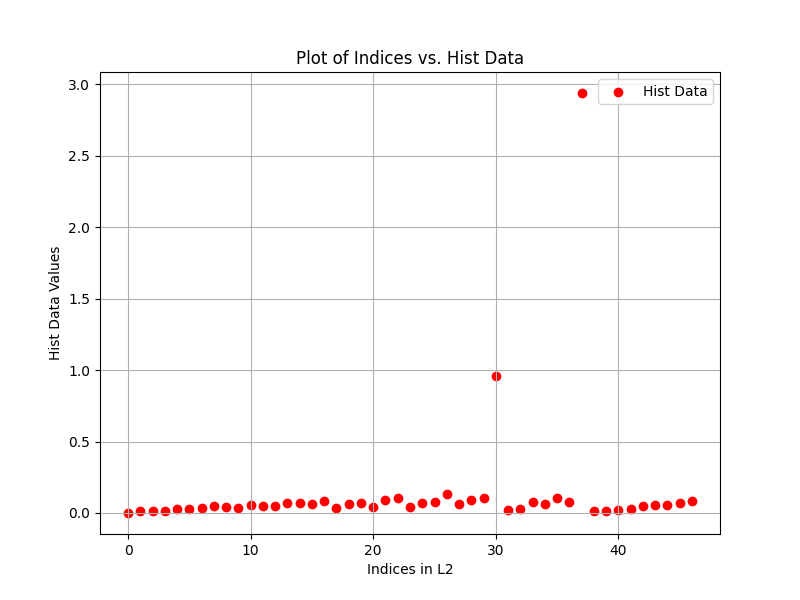

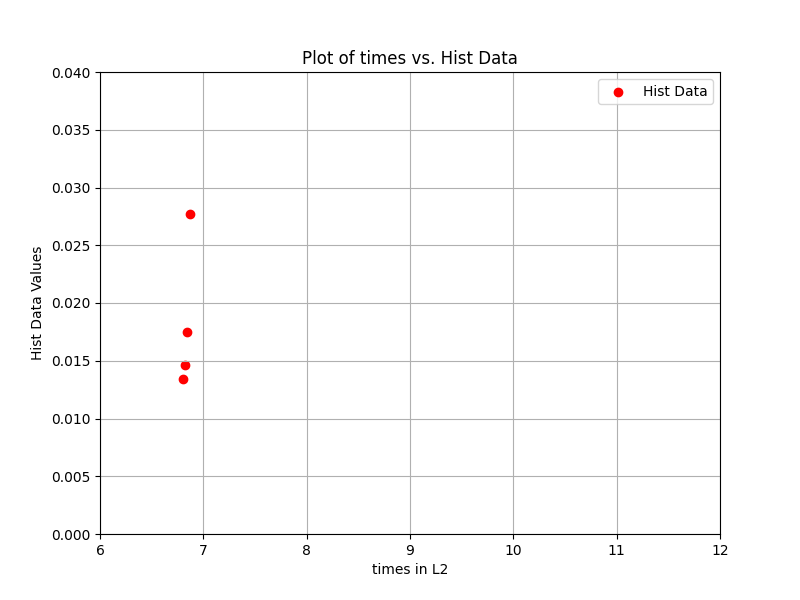

In [36]:
plt.figure(figsize=(8, 6))
plt.scatter(indices, hist_values, marker='o', color='r', label="Hist Data")
plt.xlabel("Indices in L2")
plt.ylabel("Hist Data Values")
plt.title("Plot of Indices vs. Hist Data")
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 6))
plt.scatter(times, hist_values, marker='o', color='r', label="Hist Data")
plt.xlabel("times in L2")
plt.ylabel("Hist Data Values")
plt.title("Plot of times vs. Hist Data")
plt.xlim((6,12))
plt.ylim((0,0.04))
plt.legend()
plt.grid(True)
plt.show()
# Save figure in PDF
plt.savefig("BurstDetection_Cell89(06)_Sweep15_ISI.pdf", format="pdf", bbox_inches="tight")

In [37]:
def plot_fitted_polynomial(L, degree=2):
    plt.figure(figsize=(10, 6))
    
    for sublist in L:
        if len(sublist) < 2:  # Skip empty or single-point sublists
            continue
        
        x = np.array([point[0] for point in sublist])  # Extract 1st column (times)
        y = np.array([point[2] for point in sublist])  # Extract 3rd column (hist_data values)
        
        # Scatter plot of original points
        plt.scatter(x, y, label=f"Data (Len={len(sublist)})")

        # Fit a polynomial
        coeffs = np.polyfit(x, y, degree)
        poly_func = np.poly1d(coeffs)

        # Generate smooth x values for plotting the curve
        x_smooth = np.linspace(min(x), max(x), 100)
        y_smooth = poly_func(x_smooth)

        # Plot the fitted polynomial
        plt.plot(x_smooth, y_smooth, linestyle='-', label=f"Fit (deg={degree})")
    
    plt.xlabel("Times")
    plt.ylabel("Hist Data")
    plt.title("Polynomial Fit of Categorized Data")
    plt.legend()
    plt.show()

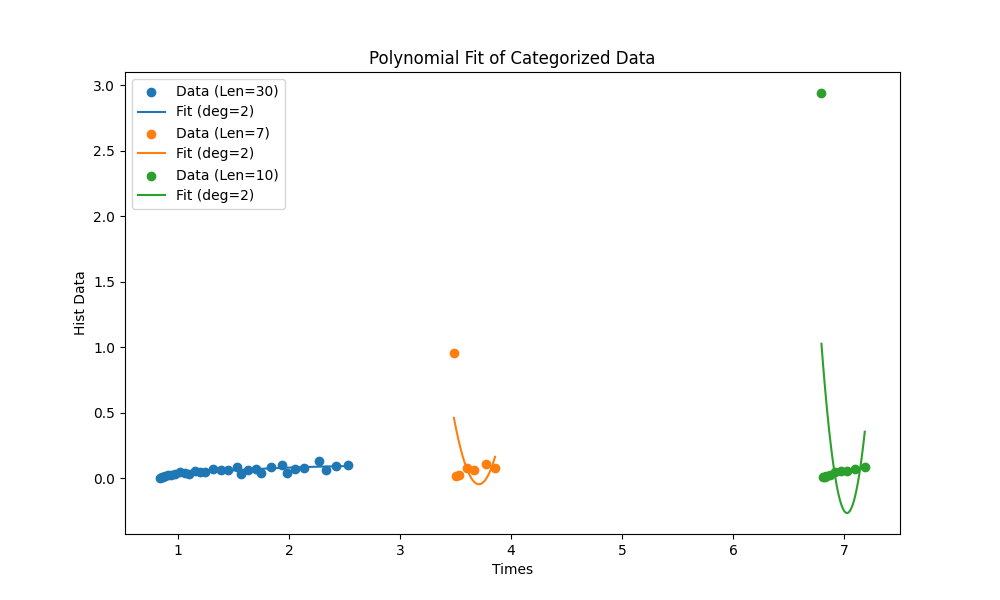

(0.0, 0.4)

In [38]:
plot_fitted_polynomial(L3ext)
plt.xlim((0,21))
plt.ylim((0,0.4))